# Install dependencies


In [1]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx
try:
  import gmsh
except ImportError:
  !pip install gmsh

In [2]:
try:
  import polyhedral_net_splines as pns
except ImportError:
  from google.colab import files
  uploaded = files.upload()
  !unzip polyhedral_splines.zip -d polyhedral_splines
  !pip install cmake
  !rm -rf polyhedral_splines.zip
  %cd polyhedral_splines/polyhedral_splines
  !pip install .
  %cd ../..



In [3]:
import dolfinx
import basix
import ufl
from mpi4py import MPI
from dolfinx.fem.petsc import LinearProblem
import numpy
import polyhedral_net_splines as pns
import numpy as np
import pyvista as pv
import inspect

In [4]:
#for gmsh
!apt-get update
!apt-get install -y libglu1-mesa

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cli.github.com/packages stable InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [5]:
from mpi4py import MPI
from petsc4py import PETSc

import os
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tqdm.autonotebook

from pyvista import examples
import imageio


import basix
from basix import CellType, ElementFamily, LagrangeVariant, SobolevSpace
from basix.ufl import element

import ufl
from ufl import (FacetNormal, Identity, Measure, TestFunction, TrialFunction,
                 as_vector, div, dot, ds, dx, inner, lhs, grad,
                 nabla_grad, rhs, sym, system, SpatialCoordinate)

from dolfinx import mesh, io, plot, fem
from dolfinx.mesh import (create_unit_square, CellType as DFXCellType,
                          create_unit_interval, create_mesh,
                          meshtags_from_entities, create_unit_cube, create_box)
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.cpp.io import perm_gmsh

from dolfinx.fem import (Constant, Function, functionspace,
                         assemble_scalar, dirichletbc, form,
                         locate_dofs_geometrical, locate_dofs_topological,
                         set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix,
                               assemble_vector, create_vector,
                               create_matrix, set_bc)
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import (VTXWriter, XDMFFile, distribute_entity_data)
from dolfinx.io import gmsh as dfx_gmesh
from dolfinx.plot import vtk_mesh
from dolfinx.graph import adjacencylist
from dolfinx.geometry import (bb_tree, compute_collisions_points,
                              compute_colliding_cells)
import gmsh

# PNS FEM

In [39]:

import typing
from petsc4py import PETSc
from dolfinx.fem import assemble_matrix, apply_lifting, create_form, extract_function_spaces
import dolfinx.fem.petsc
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, create_matrix, _create_form, create_vector, NonlinearProblem, LinearProblem
import itertools
import functools
from mpi4py import MPI
import ufl
from ufl import derivative
import numpy as np
import polyhedral_net_splines as pns
import basix
from tqdm import tqdm
import numpy as np
from ufl.algorithms import extract_coefficients

In [40]:
import time
from functools import wraps
from contextlib import contextmanager

# Store total times
total_times = {}

# Thread-local (or global) exclusion time store
_excluded_time = {}

@contextmanager
def exclude_time():
    thread_id = 'default'  # In real multi-threaded code, use threading.get_ident()
    start = time.perf_counter()
    yield
    end = time.perf_counter()
    _excluded_time[thread_id] = _excluded_time.get(thread_id, 0) + (end - start)

def track_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        thread_id = 'default'
        _excluded_time[thread_id] = 0  # Reset before each call
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        elapsed = end - start - _excluded_time[thread_id]
        total_times[func.__name__] = total_times.get(func.__name__, 0) + elapsed
        return result
    return wrapper

In [41]:
cubicLagrangeDofOrder = [0, 6, 7, 2, 4, 12, 14, 10, 5, 13, 15, 11, 1, 8, 9, 3]
cubicLagrangeDofOrderInv = [0, 12, 3, 15, 4, 8, 1, 2, 13, 14, 7, 11, 5, 9, 6, 10]

In [42]:
def assemble_prolongation_matrix(pnsObject) -> PETSc.Mat:
    """Construct Prolongation matrix of size (numBBcoeffs, numPnsCP)

    Args:
        pnsObject: PNS object

    Returns:
        Prolongation matrix
    """
    comm = pnsObject['comm']

    numBB = pnsObject['numPatches'] * 16
    numPns = pnsObject['numVerts']
    K = PETSc.Mat().createAIJ(size=(numBB, numPns), comm=comm)
    K.setUp()
    currCp = 0
    for pb in pnsObject['lagrangePatchBuilders']:
        neighborhood = pb.neighbor_verts
        mask = pb.mask
        for maskIdx in range(len(mask)):
            rowIdx = (maskIdx//16)*16 + cubicLagrangeDofOrderInv[maskIdx % 16]
            cpRow = mask[rowIdx]
            u, inv = np.unique(neighborhood, return_inverse=True)
            coeffs = dict(zip(u, np.bincount(inv, weights=cpRow)))
            for neighbor in coeffs:
                K[currCp, neighbor] = coeffs[neighbor]
            currCp += 1
    K.assemble()
    return K

In [60]:
@track_time
def assemble_matrix_pns(pnsObject, a, bc = None, lagrange_bcs=[], result = None, A = None, AK = None, KTAK = None):
    """Assemble bilinear form into a matrix for PNS.
    Args:
        pnsObject: PNS object
        a: Bilinear UFL form or a sequence of sequence of bilinear
            forms, the left hand side of the variational problem.
        bc: Dirichlet boundary condition with PNS DOF.
        lagrange_bcs: Lagrange basis Dirichlet boundary conditions.
        result: Optional Matrix to assemble the bilinear form into.
        A: Bilinear form matrix in Lagrange basis
        AK: Bilinear form matrix in Lagrange basis
        KTAK: Temprory as setting to result directly without copy not working.
    Returns:
        Bilinear form matrix for PNS.
        Bilinear form matrix in Lagrange basis(no BC)
    """
    comm = pnsObject['comm']

    with exclude_time():
        if A is None:
            A = create_matrix(a)
        A.zeroEntries()
        A = dolfinx.fem.petsc.assemble_matrix(A, a, bcs=lagrange_bcs)
        # A.assemble()
    K = pnsObject['prolongation_matrix']

    AK = A.matMult(K, result=AK)

    KTAK = K.transposeMatMult(AK, result = KTAK)
    if bc is not None:
        bc.setMatrix(KTAK)
    # KTAK.assemble()
    if result is not None:
        KTAK.copy(result)
    return KTAK, A


In [44]:
@track_time
def assemble_vector_pns(pnsObject, L, A = None, bc = None, lagrange_bcs=[], bilinear_form=None, result = None, x0=None, alpha=1.0, b = None):
    """Assemble linear form into a vector for PNS.
    Args:
        pnsObject: PNS object
        L: Linear UFL form or a sequence of linear forms, the right
            hand side of the variational problem.
        A: Bilinear form matrix in Lagrange basis
        bc: Dirichlet boundary condition with PNS DOF.
        lagrange_bcs: Lagrange basis Dirichlet boundary conditions.
        bilinear_form: Bilinear form in Lagrange basis. Required if applying lagrange bcs.
        result: Optional Vector to assemble the linear form into.
        x0: For BC
        alpha: For BC
        b: Optional vector to store the temopary vector for Lagrange basis.
    Returns:
        Linear form vector for PNS.
    """
    comm = pnsObject['comm']
    if result is None:
        result = PETSc.Vec().createSeq(pnsObject['numVerts'], comm=comm)
    K = pnsObject['prolongation_matrix']
    with exclude_time():
        if b is None:
            b = create_vector(extract_function_spaces(L))
        with b.localForm() as bl:
            bl.set(0)
        dolfinx.fem.petsc.assemble_vector(b, L)
        if len(lagrange_bcs) > 0:
            dolfinx.fem.petsc.apply_lifting(b, [bilinear_form], [lagrange_bcs], x0=[x0] if x0 is not None else [], alpha=alpha)
            dolfinx.fem.petsc.set_bc(b, lagrange_bcs, x0=x0, alpha=alpha)
    lifted_b = b # if no pns BC

    # TODO: account for x0 and alpha
    if bc is not None:
        AK = A.matMult(K)
        x_g = bc.getXg()
        lifted_b = PETSc.Vec().createSeq(K.getSize()[0], comm=comm)
        AK.mult(x_g, lifted_b)
        lifted_b.aypx(-1, b)
    K.multTranspose(lifted_b, result)
    if bc is not None:
        bc.setVector(result)
    result.assemble()
    return result, b



In [45]:
def pnsAssign(source_pns: PETSc.Vec, target_lagrange: dolfinx.fem.Function, pnsObject):
    """Assign the value from source vector in Lagrange basis to target vector in PNS basis.
    Args:
        source_pns: Source vector in PNS basis.
        target_lagrange: Target function in Lagrange basis.
        pnsObject: PNS object
    """
    K = pnsObject['prolongation_matrix']
    K.mult(source_pns, target_lagrange.x.petsc_vec)

In [46]:
def pnsLagrangeAssign(source_lagrange: dolfinx.fem.Function, target_pns: PETSc.Vec, pnsObject):
    """Assign the value from source vector in PNS basis to target vector in Lagrange basis.
    Args:
        source_lagrange: Source function in PNS basis.
        target_pns: Target vector in Lagrange basis.
        pnsObject: PNS object
    """
    K = pnsObject['prolongation_matrix']
    K.multTranspose(source_lagrange.x.petsc_vec, target_pns)

In [47]:
class PnsLinearProblem:
    def __init__(
        self,
        a: ufl.Form,
        L: ufl.Form,
        pnsObject,
        bc: typing.Optional[dolfinx.fem.DirichletBC] = None,
        lagrange_bcs = [],
        comm = MPI.COMM_WORLD,
        petsc_options: typing.Optional[dict] = None,
        form_compiler_options: typing.Optional[dict] = None,
        jit_options: typing.Optional[dict] = None,
    ):
        """Initialize solver for a linear variational problem.

        Args:
            a: Bilinear UFL form or a sequence of sequence of bilinear
                forms, the left hand side of the variational problem.
            L: Linear UFL form or a sequence of linear forms, the right
                hand side of the variational problem.
            pnsObject: PNS object
            bc(PnsDirichletBC): Dirichlet boundary condition with PNS DOF.
            lagrange_bcs: Lagrange basis Dirichlet boundary conditions.
            petsc_options: Options that are passed to the linear
                algebra backend PETSc. For available choices for the
                'petsc_options' kwarg, see the `PETSc documentation
                <https://petsc4py.readthedocs.io/en/stable/manual/ksp/>`_.
            form_compiler_options: Options used in FFCx compilation of
                all forms. Run ``ffcx --help`` at the commandline to see
                all available options.
            jit_options: Options used in CFFI JIT compilation of C
                code generated by FFCx. See `python/dolfinx/jit.py` for
                all available options. Takes priority over all other
                option values.

        Example::

            problem = LinearProblem(a, L, bc, petsc_options={
                "ksp_type": "preonly",
                "pc_type": "lu",
                "pc_factor_mat_solver_type": "mumps"
            })
        """
        # Maybe u needs to be in pns for.
        # Create K. Maybe k can be represended as a form then create_matrix function can be used
        self.pnsObject = pnsObject
        self._a = dolfinx.fem.form(a)
        self._L = dolfinx.fem.form(L)

        self.bc = bc
        self.lagrange_bcs = lagrange_bcs

        comm = pnsObject['comm']

        self._solver = PETSc.KSP().create(comm)
        prefix = f"dolfinx_solve_{id(self)}"
        self._solver.setOptionsPrefix(prefix)

        opts = PETSc.Options()
        opts.prefixPush(prefix)
        if petsc_options:
            for key, val in petsc_options.items():
                opts[key] = val
        opts.prefixPop()
        self._solver.setFromOptions()

    def solve(self) -> PETSc.Vec:
        A_reduced, A = assemble_matrix_pns(self.pnsObject, self._a, self.bc, self.lagrange_bcs)
        b_reduced, _ = assemble_vector_pns(self.pnsObject, self._L, A, self.bc, self.lagrange_bcs, self._a)
        self._solver.setOperators(A_reduced)
        x_reduced = b_reduced.duplicate()
        self._solver.solve(b_reduced, x_reduced)

        return x_reduced

    def __del__(self):
        return


In [48]:
def assemble_jacobian_pns(
        u: dolfinx.fem.Function,
        jacobian: typing.Union[dolfinx.fem.Form, typing.Iterable[typing.Iterable[dolfinx.fem.Form]]],
        pnsObject,
        lagrange_bcs: typing.Iterable[dolfinx.fem.DirichletBC],
        A, AK, KTAK,
        _snes: PETSc.SNES,  # type: ignore
        x: PETSc.Vec,  # type: ignore
        J: PETSc.Mat,  # type: ignore
        P: PETSc.Mat,  # type: ignore
):
    """Assemble Jacobian for PNS.
    Args:
        u: Function tied to the solution vector within the residual and
            jacobian.
        jacobian: Compiled form of the Jacobian.
        pnsObject
        lagrange_bcs: List of Dirichlet boundary conditions to apply to the Jacobian
        _snes: The solver instance.
        A, AK, KTAK: Temprory Mats for performance
        x: The vector containing the point to evaluate at.
        J: Matrix to assemble the Jacobian into.
        P: Matrix to assemble the preconditioner into.
    """
    # Copy existing soultion into the function used in the residual and
    # Jacobian
    # try:
    #     x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)  # type: ignore
    # except PETSc.Error:  # type: ignore
    #     for x_sub in x.getNestSubVecs():
    #         x_sub.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)  # type: ignore
    pnsAssign(x, u, pnsObject)

    assemble_matrix_pns(pnsObject, jacobian, lagrange_bcs=lagrange_bcs, result = J, A=A, AK=AK, KTAK=KTAK)

In [49]:
def assemble_residual_pns(
    u: typing.Union[dolfinx.fem.Function, typing.Sequence[dolfinx.fem.Function]],
    residual: typing.Union[dolfinx.fem.Form, typing.Iterable[dolfinx.fem.Form]],
    jacobian: typing.Union[dolfinx.fem.Form, typing.Iterable[typing.Iterable[dolfinx.fem.Form]]],
    pnsObject,
    bcs: typing.Iterable[dolfinx.fem.DirichletBC],
    bTemp: PETSc.Vec,
    _snes: PETSc.SNES,  # type: ignore
    x: PETSc.Vec,  # type: ignore
    b: PETSc.Vec,  # type: ignore
):
    """Assemble the residual into the vector `b`.

    A function conforming to the interface expected by SNES.setResidual can
    be created by fixing the first four arguments:

        functools.partial(assemble_residual, u, residual, jacobian, bcs)

    Args:
        u: Function(s) tied to the solution vector within the residual and
           Jacobian.
        residual: Form of the residual. It can be a sequence of forms.
        jacobian: Form of the Jacobian. It can be a nested sequence of
            forms.
        pnsObject
        bcs: List of Dirichlet boundary conditions to lift the residual.
        bTemp: Temporary vector to store the temopary vector for Lagrange basis.
        _snes: The solver instance.
        x: The vector containing the point to evaluate the residual at.
        b: Vector to assemble the residual into.
    """
    # Update input vector before assigning
    # _ghostUpdate(x, PETSc.InsertMode.INSERT, PETSc.ScatterMode.FORWARD)  # type: ignore

    # Assign the input vector to the unknowns
    pnsAssign(x, u, pnsObject)

    assemble_vector_pns(pnsObject, residual, lagrange_bcs=bcs, bilinear_form=jacobian, result=b, x0=x, alpha=-1.0, b=bTemp)
    # _ghostUpdate(b, PETSc.InsertMode.INSERT, PETSc.ScatterMode.FORWARD)  # type: ignore

In [50]:
class PnsNonlinearProblem:
    def __init__(
        self,
        F: typing.Union[ufl.form.Form, typing.Sequence[ufl.form.Form]],
        u: typing.Union[dolfinx.fem.function.Function, typing.Sequence[dolfinx.fem.function.Function]],
        pnsObject,
        lagrange_bcs: typing.Optional[typing.Sequence[dolfinx.fem.DirichletBC]] = None,
        J: typing.Optional[typing.Union[ufl.form.Form, typing.Sequence[typing.Sequence[ufl.form.Form]]]] = None,
        form_compiler_options: typing.Optional[dict] = None,
        jit_options: typing.Optional[dict] = None,
        petsc_options: typing.Optional[dict] = None,
        entity_maps: typing.Optional[dict[dolfinx.mesh.Mesh, np.typing.NDArray[np.int32]]] = None,
    ):
        """Class for solving nonlinear problems on PNS with SNES.



        Solves problems of the form
        :math:`F_i(u, v) = 0, i=0,...N\\ \\forall v \\in V` where
        :math:`u=(u_0,...,u_N), v=(v_0,...,v_N)` using PETSc SNES as the
        non-linear solver.

        By default, the underlying SNES solver uses PETSc's default
        options. To use the robust combination of LU via MUMPS with
        a backtracking linesearch, pass:

        Example::

            petsc_options = {"ksp_type": "preonly",
                             "pc_type": "lu",
                             "pc_factor_mat_solver_type": "mumps",
                             "snes_linesearch_type": "bt",
            }

        Note:
            The deprecated version of this class for use with
            NewtonSolver has been renamed NewtonSolverNonlinearProblem.

        Args:
            F: UFL form(s) representing the residual :math:`F_i`.
            u: Function(s) used to define the residual and Jacobian.
            pnsObject: PNS object
            bcs: Dirichlet boundary conditions.
            J: UFL form(s) representing the Jacobian
                :math:`J_ij = dF_i/du_j`. If not passed, derived
                automatically.
            form_compiler_options: Options used in FFCx compilation of all
                forms. Run ``ffcx --help`` at the command line to see all
                available options.
            jit_options: Options used in CFFI JIT compilation of C code
                generated by FFCx. See ``python/dolfinx/jit.py`` for all
                available options. Takes priority over all other option
                values.
            petsc_options: Options that are set on the underlying
                PETSc SNES object only. For available choices for the
                'petsc_options' kwarg, see the `PETSc SNES documentation
                <https://petsc4py.readthedocs.io/en/stable/manual/snes>`_.
                Options on other objects (matrices, vectors) should be set
                explicitly by the user.
            entity_maps: If any trial functions, test functions, or
                coefficients in the form are not defined over the same mesh
                as the integration domain, ``entity_maps`` must be
                supplied. For each key (a mesh, different to the
                integration domain mesh) a map should be provided relating
                the entities in the integration domain mesh to the entities
                in the key mesh e.g. for a key-value pair ``(msh, emap)``
                in ``entity_maps``, ``emap[i]`` is the entity in ``msh``
                corresponding to entity ``i`` in the integration domain
                mesh.
        """
        self.pnsObject = pnsObject
        # Compile residual and Jacobian forms
        self._F = _create_form(
            F,
            form_compiler_options=form_compiler_options,
            jit_options=jit_options,
            entity_maps=entity_maps
        )

        # Create the Jacobian matrix, dF/du
        if J is None:
            V = u.function_space
            du = ufl.TrialFunction(V)
            J = ufl.derivative(F, u, du)

        self._J = _create_form(
            J,
            form_compiler_options=form_compiler_options,
            jit_options=jit_options,
            entity_maps=entity_maps,
        )

        self._u = u
        # Set default values if not supplied
        bcs = [] if lagrange_bcs is None else lagrange_bcs
        # Create PETSc structures for the residual, Jacobian and solution
        # vector

        comm = pnsObject['comm']
        self._x = PETSc.Vec().createSeq(pnsObject['numVerts'], comm=comm)
        self._b = PETSc.Vec().createSeq(pnsObject['numVerts'], comm=comm)
        Jmat = PETSc.Mat()
        bTemp = create_vector(extract_function_spaces(self._F))
        Atemp = create_matrix(self._J)
        AKtemp = PETSc.Mat()
        KTAKtemp = PETSc.Mat()

        # Create the SNES solver and attach the corresponding Jacobian and
        # residual computation functions
        self._snes = PETSc.SNES().create(comm=comm)  # type: ignore
        self._snes.setJacobian(
            functools.partial(assemble_jacobian_pns, u, self._J, pnsObject, bcs, Atemp, AKtemp, KTAKtemp), Jmat, None
        )
        self._snes.setFunction(functools.partial(assemble_residual_pns, u, self._F, self._J, pnsObject, bcs, bTemp), self._b)

        # Set options for SNES only
        if petsc_options is not None:
            problem_prefix = f"dolfinx_nonlinearproblem_{id(self)}_"
            opts = PETSc.Options()  # type: ignore
            opts.prefixPush(problem_prefix)

            for k, v in petsc_options.items():
                opts[k] = v

            self._snes.setFromOptions()

            # Tidy up global options
            for k in petsc_options.keys():
                del opts[k]

            opts.prefixPop()


    def solve(self) -> tuple[PETSc.Vec, int, int]:  # type: ignore
        """Solve the problem and update the solution in the problem
        instance.

        Note:
            The user is responsible for asserting convergence of the SNES
            solver e.g. `assert converged_reason > 0`. Alternatively, pass
            `"snes_error_if_not_converged": True` and
            `"ksp_error_if_not_converged" : True` in `petsc_options`.

        Returns:
            The solution, convergence reason and number of SNES (outer)
            iterations.
        """

        # Move current iterate into the work array.
        pnsLagrangeAssign(self._u, self._x, self.pnsObject)

        # Solve problem
        self._snes.solve(None, self._x)

        # Move solution back to function
        pnsAssign(self._x, self._u, self.pnsObject)

        converged_reason = self._snes.getConvergedReason()
        return self._x, converged_reason, self._snes.getIterationNumber()

In [51]:
class PnsDirichletBC:
    def __init__(self, pnsObject, value: np.ndarray, dof: np.ndarray):
        self.value = value
        self.dof = dof
        self.pnsObject = pnsObject

    def setVector(self, x: PETSc.Vec):
        x.setValues(self.dof, self.value)
        x.assemble()

    def setMatrix(self, mat: PETSc.Mat):
        mat.zeroRowsColumns(self.dof, diag = 1)
        mat.assemble()

        # mat.zeroRows(self.dof, diag=1)

        # nrows, _ = mat.getSize()
        # all_rows = list(range(nrows))
        # # zero each column in turn
        # for j in self.dof:
        #     # set A_red[i,j] = 0 for i=0..nrows-1
        #     mat.setValues(all_rows, [j], [0.0]*nrows, PETSc.InsertMode.INSERT)
        # mat.assemble()

    def getXg(self):
        numVerts = self.pnsObject['numVerts']
        x_g = PETSc.Vec().createSeq(numVerts, comm=self.pnsObject['comm'])
        x_g.setValues(self.dof, self.value)
        x_g.assemble()
        return x_g

In [52]:
def loadPns(file_name: str, comm = MPI.COMM_WORLD):
    control_mesh = pns.Pns_control_mesh.from_file(file_name)
    pnsLagrangePatchBuilders = pns.get_patch_builders(control_mesh, )
    pnsPatchBuilders = pns.get_patch_builders(control_mesh)
    if len(pnsLagrangePatchBuilders) == 0:
        raise Exception("No patches found")
    flatPatches = []
    numPatches = 0
    for pb in pnsLagrangePatchBuilders:
        pb.toLagrange()
        # numPatches += pb.num_patches
    for pb in pnsPatchBuilders:
        for patch in pb.build_patches(control_mesh):
            flatPatches.append(patch)
            numPatches += 1
        pb.degRaise()
    numVerts = len(control_mesh.get_vertices())
    pnsObject = {'lagrangePatchBuilders': pnsLagrangePatchBuilders, 'patchBuilders': pnsPatchBuilders, 'numPatches': numPatches, 'numVerts': numVerts, 'control_mesh': control_mesh, "flat_patches": flatPatches, "comm": comm}
    K = assemble_prolongation_matrix(pnsObject)
    pnsObject["prolongation_matrix"] = K
    return pnsObject

In [53]:
def createPnsDolfinxMesh(pnsObject) -> dolfinx.mesh.Mesh:
    x = []
    cells = []
    idx = 0
    temp = 0
    for pb in pnsObject['lagrangePatchBuilders']:
        lagrangePatches = pb.build_patches(pnsObject['control_mesh'])
        for patch in lagrangePatches:
            temp += 1
            lagrangeCoeffs = patch.bb_coefs
            currX = [0]*16
            cpIdx = 0
            for row in lagrangeCoeffs:
                for col in row:
                    currX[cubicLagrangeDofOrder[cpIdx]] = [col[0], col[1], col[2]]
                    cpIdx += 1
            x.extend(currX)
            cells.append(list(range(idx, idx+16)))
            idx += 16
    domain = ufl.Mesh(
        basix.ufl.element(
            "Lagrange",
            "quadrilateral",
            3,
            lagrange_variant=basix.LagrangeVariant.equispaced,
            shape=(3,),
        )
    )

    mesh = dolfinx.mesh.create_mesh(pnsObject["comm"], cells, domain, x)
    return mesh


In [54]:
def pnsFunctionSpace(mesh, element) -> dolfinx.fem.FunctionSpace:
    V = dolfinx.fem.functionspace(mesh, element)
    return V


In [55]:
def testProlongationMatrix(pnsObject):
    K = assemble_prolongation_matrix(pnsObject)
    comm = pnsObject["comm"]
    numVerts   = pnsObject["numVerts"]
    numPatches = pnsObject["numPatches"]

    x = PETSc.Vec().createSeq(numVerts, comm=comm)
    ids = np.arange(numVerts, dtype=np.int32)
    vals = [a[0] for a in pnsObject['control_mesh'].get_vertices()]
    x.setValues(ids, vals)
    x.assemble()


    y = PETSc.Vec().createSeq(numPatches*16, comm=comm)
    K.mult(x, y)
    y_arr = y.getArray()

    offset = 0
    for pb in pnsObject["lagrangePatchBuilders"]:
        patches = pb.build_patches(pnsObject['control_mesh'])
        for patch in patches:
            bb = np.asarray(patch.bb_coefs)[:, :, 0].reshape(16,)
            y_patch = y_arr[offset : offset + 16]
            y_reordered = y_patch[cubicLagrangeDofOrder]
            assert np.allclose(y_reordered, bb, atol=1e-12), (
                f"Patch at offset {offset}: "
                f"expected {bb}, got {y_reordered}"
            )
            offset += 16
    assert offset == numPatches*16
    print("✓ Prolongation matrix matches patch bb_coeffs")


In [56]:
# testProlongationMatrix(pnsObject)

## Visualize Pns

In [57]:
from IPython.display import HTML, display
import numpy as np
import json
from math import comb
from functools import cache

class PnsVisualizer:
    def __init__(self, pnsObject, dt=0):
        self.pnsObject = pnsObject
        self.dt = dt
        self.funcList = []

    def addFunc(self, valDofs):
        self.funcList.append(valDofs.copy())

    def visualizePns(self,
                     expectedResult = None,
                     valRange = None,
                     showContour=True,
                     colorMap='blackbody',
                     res_u=20, res_v=20,
                     width=800, height=600, saveToFile = False):
        """
        Render time‐dependent PNS patches with a GUI slider.
        colorMap: 'rainbow','cooltowarm','blackbody','grayscale'
        """
        us = np.linspace(0, 1, res_u)
        vs = np.linspace(0, 1, res_v)

        @cache
        def bernstein(i, t):
            return comb(3, i) * (t**i) * ((1 - t)**(3 - i))

        # 1) Build static mesh positions & faces
        allPatchCps = np.array([
            patch.bb_coefs
            for pb in self.pnsObject['patchBuilders']
            for patch in pb.build_patches(self.pnsObject['control_mesh'])
        ])  # shape (P,4,4,3)
        P = allPatchCps.shape[0]

        Bu = np.array([[bernstein(i, u) for i in range(4)] for u in us])  # (res_u,4)
        Bv = np.array([[bernstein(j, v) for j in range(4)] for v in vs])  # (res_v,4)

        pts = np.empty((P, res_u, res_v, 3))
        for k in range(3):
            pts[..., k] = np.einsum('ui,pij,vj->puv', Bu, allPatchCps[..., k], Bv)

        vertices = pts.reshape(-1, 3).tolist()

        idx = np.arange(res_u * res_v).reshape(res_u, res_v)
        I0 = idx[:-1, :-1].ravel()
        I1 = idx[1:,  :-1].ravel()
        I2 = idx[1:,   1:].ravel()
        I3 = idx[:-1,  1:].ravel()
        F0 = np.vstack([
            np.stack([I0, I1, I2], axis=1),
            np.stack([I0, I2, I3], axis=1)
        ])  # (2*(res_u-1)*(res_v-1),3)

        faces = (
            F0[None, :, :] +
            (res_u * res_v) * np.arange(P)[:, None, None]
        ).reshape(-1, 3).tolist()

        # 2) Precompute scalar arrays for each time‐step
        vals_all = []
        positions = np.array(vertices)
        for valDofs in self.funcList:
            # build val‐function control‐point arrays
            valPatchCps = np.array([
                patch.bb_coefs
                for pb in self.pnsObject['patchBuilders']
                for patch in pb.build_patches(
                    pns.Pns_control_mesh.from_data(
                        [(v,0,0) for v in valDofs],
                        []
                    )
                )
            ])  # shape (P,4,4,3)

            valCtrl = valPatchCps[..., 0]  # extract the scalar from x‐coord
            spts = np.einsum('ui,pij,vj->puv', Bu, valCtrl, Bv)  # (P,res_u,res_v)
            s_flat = spts.reshape(-1)

            if expectedResult is not None:
                s_flat = np.abs(s_flat - np.array([
                    expectedResult(tuple(pt)) for pt in positions
                ]))

            vals_all.append(s_flat.tolist())


        global_min = min(min(arr) for arr in vals_all)
        global_max = max(max(arr) for arr in vals_all)
        print(f"Range min: {global_min}")
        print(f"Range max: {global_max}")
        if valRange is not None:
            global_min, global_max = valRange
            print(f"Render Range - {global_min}:{global_max}")



        # 4) JSONify
        verts_json    = json.dumps(vertices)
        faces_json    = json.dumps(faces)
        vals_json_all = json.dumps(vals_all)
        min_json      = json.dumps(global_min)
        max_json      = json.dumps(global_max)

        # 5) Build HTML/JS with RawShaderMaterial
        html = f"""
<div id="bezier-view" style="width:{width}px; height:{height}px;"></div>
<script type="importmap">
{{
  "imports": {{
    "three":         "https://cdn.jsdelivr.net/npm/three@0.167.1/build/three.module.js",
    "three/addons/": "https://cdn.jsdelivr.net/npm/three@0.167.1/examples/jsm/"
  }}
}}
</script>
<script type="module">
import * as THREE         from 'three';
import {{ OrbitControls }} from 'three/addons/controls/OrbitControls.js';
import {{ Lut }}           from 'three/addons/math/Lut.js';
import {{ GUI }}           from 'three/addons/libs/lil-gui.module.min.js';

// SCENE SETUP
const container = document.getElementById('bezier-view');
const scene     = new THREE.Scene();
scene.background = new THREE.Color(0xffffff);
const camera    = new THREE.PerspectiveCamera(45, {width}/{height}, 0.1, 1000);
camera.position.set(0,10,20);
camera.lookAt(0,0,0);

const renderer = new THREE.WebGLRenderer({{ antialias: true }});
renderer.setSize({width}, {height});
renderer.autoClear = false;
container.appendChild(renderer.domElement);

// STATIC GEOMETRY
const verts = {verts_json};
const faces = {faces_json};
const geom  = new THREE.BufferGeometry();
geom.setAttribute('position',
  new THREE.BufferAttribute(new Float32Array(verts.flat()), 3)
);
geom.setIndex(
  new THREE.BufferAttribute(new Uint32Array(faces.flat()), 1)
);
geom.computeVertexNormals();

// SCALAR FIELDS & LUT
const vals_all = {vals_json_all};
const lut      = new Lut('{colorMap}', 512);
lut.setMin({min_json});
lut.setMax({max_json});

// LUT LEGEND
const uiScene   = new THREE.Scene();
const orthoCam  = new THREE.OrthographicCamera(-1,1,1,-1,1,2);
orthoCam.position.set(0.9, 0, 1);
const sprite    = new THREE.Sprite(new THREE.SpriteMaterial({{
  map: new THREE.CanvasTexture(lut.createCanvas())
}}));
sprite.material.map.colorSpace = THREE.SRGBColorSpace;
sprite.scale.x = 0.125;
uiScene.add(sprite);

// BUFFERS
const N = vals_all[0].length;
const colorArr  = new Float32Array(N*3);
const scalarArr = new Float32Array(vals_all[0]);
geom.setAttribute('color',
  new THREE.BufferAttribute(colorArr, 3)
);
geom.setAttribute('scalar',
  new THREE.BufferAttribute(scalarArr, 1)
);

// SHADERS
const vertexShader = `
attribute vec3 position;
attribute vec3 color;
attribute float scalar;
uniform mat4 modelViewMatrix;
uniform mat4 projectionMatrix;
varying vec3 vColor;
varying float vScalar;
void main() {{
  vColor    = color;
  vScalar   = scalar;
  gl_Position = projectionMatrix * modelViewMatrix * vec4(position, 1.0);
}}
`;
const fragmentShader = `
precision highp float;
varying vec3 vColor;
varying float vScalar;
uniform float minVal;
uniform float maxVal;
uniform float nIso;
void main() {{
  float t       = (vScalar - minVal) / (maxVal - minVal);
  float isoDist = abs(fract(t * nIso) - 0.5);
  float line    = 1.0 - step(0.02, isoDist);
  vec3 outC     = mix(vColor, vec3(1.0), line);
  gl_FragColor  = vec4(outC, 1.0);
}}
`;

// RAW SHADER MATERIAL
const rawMat = new THREE.RawShaderMaterial({{
  vertexShader:   vertexShader,
  fragmentShader: fragmentShader,
  uniforms: {{
    minVal: {{ value: {min_json} }},
    maxVal: {{ value: {max_json} }},
    nIso:   {{ value: {10 if showContour else 0} }}
  }},
  vertexColors: true,
  side: THREE.DoubleSide
}});

// MESH & CONTROLS
const mesh = new THREE.Mesh(geom, rawMat);
scene.add(mesh);
new OrbitControls(camera, renderer.domElement).update();

// UPDATE COLORS & SCALARS
const onColorChange = idx => {{
  const arr = vals_all[idx];
  for (let i = 0; i < N; i++) {{
    const c = lut.getColor(arr[i]);
    colorArr[3*i]   = c.r;
    colorArr[3*i+1] = c.g;
    colorArr[3*i+2] = c.b;
    scalarArr[i]    = arr[i];
  }}
  geom.attributes.color.needsUpdate  = true;
  geom.attributes.scalar.needsUpdate = true;
}};

// GUI SLIDER
if (vals_all.length > 1) {{
  const gui = new GUI();
  const params = {{ t: 0 }};
  gui.add(params, 't', 0, vals_all.length-1, 1)
     .name('time')
     .onChange(onColorChange);
}}
onColorChange(0);

// GRID HELPER
const gridHelper = new THREE.GridHelper(20, 10);
gridHelper.material.opacity     = 0.2;
gridHelper.material.transparent = true;
gridHelper.position.y           = -1;
scene.add(gridHelper);

// RENDER LOOP
function animate() {{
  requestAnimationFrame(animate);
  renderer.clear();
  renderer.render(scene, camera);
  renderer.clearDepth();
  renderer.render(uiScene, orthoCam);
}}
animate();
</script>
"""
        if saveToFile:
            with open("drive/MyDrive/result.html", "w") as f:
                f.write(html)
        print("Rendering...")

        display(HTML(html))


### Visualize lagrange DOF order

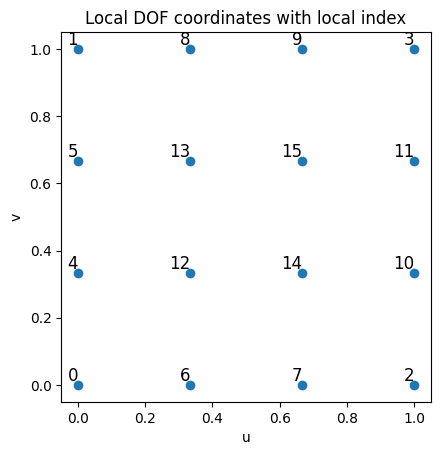

In [58]:
import matplotlib.pyplot as plt
mTemp = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 1, 1, dolfinx.mesh.CellType.quadrilateral)
VTemp = dolfinx.fem.functionspace(mTemp, basix.ufl.element("Lagrange", "quadrilateral", 3, lagrange_variant=basix.LagrangeVariant.equispaced,))
local_coords = [(float(d[0]), float(d[1])) for d in VTemp.tabulate_dof_coordinates()[:16]]
xs, ys = zip(*local_coords)
plt.figure()
plt.scatter(xs, ys)
for idx, (x, y) in enumerate(local_coords):
    plt.text(x, y, str(idx), fontsize=12, ha='right', va='bottom')
plt.xlabel("u")
plt.ylabel("v")
plt.title("Local DOF coordinates with local index")
plt.gca().set_aspect('equal', 'box')
plt.show()

In [59]:
[0, 12, 3, 4, 8, 1, 2, 13, 14, 7, 11, 5, 96, ]

[0, 12, 3, 4, 8, 1, 2, 13, 14, 7, 11, 5, 96]

# GMSH


In [ ]:
warnings.filterwarnings("ignore")
gmsh.initialize()


In [ ]:
gmsh.model.add("DFG 3D")
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.5)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.5)
L, B, H, r = 2.5, 0.41, 0.41, 0.1
channel = gmsh.model.occ.addBox(0, 0, 0, L, B, H)

In [ ]:
cylinder = gmsh.model.occ.addCylinder(0.5, 0, 0.2, 0, B, 0, r)
fluid = gmsh.model.occ.cut([(3, channel)], [(3, cylinder)])

In [ ]:
gmsh.model.occ.synchronize()
volumes = gmsh.model.getEntities(dim=3)
assert volumes == fluid[0]
fluid_marker = 11
gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid volume")

In [ ]:
surfaces = gmsh.model.occ.getEntities(dim=2)
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 1, 3, 5, 7
walls = []
obstacles = []
for surface in surfaces:
    com = gmsh.model.occ.getCenterOfMass(surface[0], surface[1])
    if np.allclose(com, [0, B / 2, H / 2]):
        gmsh.model.addPhysicalGroup(surface[0], [surface[1]], inlet_marker)
        inlet = surface[1]
        print("Inlet Defined")
        gmsh.model.setPhysicalName(surface[0], inlet_marker, "Fluid inlet")
    elif np.allclose(com, [L, B / 2, H / 2]):
        gmsh.model.addPhysicalGroup(surface[0], [surface[1]], outlet_marker)
        gmsh.model.setPhysicalName(surface[0], outlet_marker, "Fluid outlet")
    elif (
        np.isclose(com[2], 0)
        or np.isclose(com[1], B)
        or np.isclose(com[2], H)
        or np.isclose(com[1], 0)
    ):
        walls.append(surface[1])
    else:
        obstacles.append(surface[1])
gmsh.model.addPhysicalGroup(2, walls, wall_marker)
gmsh.model.setPhysicalName(2, wall_marker, "Walls")
gmsh.model.addPhysicalGroup(2, obstacles, obstacle_marker)
gmsh.model.setPhysicalName(2, obstacle_marker, "Obstacle")

In [ ]:
distance = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumbers(distance, "FacesList", obstacles)

In [ ]:
resolution = r / 10
threshold = gmsh.model.mesh.field.add("Threshold")
gmsh.model.mesh.field.setNumber(threshold, "IField", distance)
gmsh.model.mesh.field.setNumber(threshold, "LcMin", resolution)
gmsh.model.mesh.field.setNumber(threshold, "LcMax", 20 * resolution)
gmsh.model.mesh.field.setNumber(threshold, "DistMin", 0.5 * r)
gmsh.model.mesh.field.setNumber(threshold, "DistMax", r)

In [ ]:
inlet_dist = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumbers(inlet_dist, "FacesList", [inlet])
inlet_thre = gmsh.model.mesh.field.add("Threshold")
gmsh.model.mesh.field.setNumber(inlet_thre, "IField", inlet_dist)
gmsh.model.mesh.field.setNumber(inlet_thre, "LcMin", 5 * resolution)
gmsh.model.mesh.field.setNumber(inlet_thre, "LcMax", 10 * resolution)
gmsh.model.mesh.field.setNumber(inlet_thre, "DistMin", 0.1)
gmsh.model.mesh.field.setNumber(inlet_thre, "DistMax", 0.5)

In [ ]:
minimum = gmsh.model.mesh.field.add("Min")
gmsh.model.mesh.field.setNumbers(minimum, "FieldsList", [threshold, inlet_thre])
gmsh.model.mesh.field.setAsBackgroundMesh(minimum)

In [ ]:
gmsh.model.mesh.setRecombine(3, inlet)
gmsh.model.mesh.setRecombine(3, cylinder)
gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(3)


In [ ]:
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
print("Number of nodes:", len(node_tags))

In [ ]:
gmsh.write("/content/mesh3D.obj")
#pnsObject = loadPns("mesh3D.obj", comm=MPI.COMM_WORLD)

In [ ]:
mesh = createPnsDolfinxMesh(pnsObject)
V = pnsFunctionSpace(mesh, finite_element_1)

In [ ]:

visualizer = PnsVisualizer(pnsObject)
un = PETSc.Vec().createSeq(pnsObject['numVerts'], comm=mesh.comm)
un[5]=1
visualizer.addFunc(un.array.real)
visualizer.visualizePns(colorMap='plasma')

#Navier Stokes PnS w/ Fenicsx


In [61]:

from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)


In [62]:
!ls
pnsObject = loadPns("airplane.obj", comm=MPI.COMM_WORLD)
mesh = createPnsDolfinxMesh(pnsObject)
finite_element_1 = basix.ufl.element(
    "Lagrange",
    "quadrilateral",
    3,
    lagrange_variant=basix.LagrangeVariant.equispaced,
)
finite_element_3 = basix.ufl.element(
    "Lagrange",
    "quadrilateral",
    3,
    shape = (mesh.geometry.dim,),
    lagrange_variant=basix.LagrangeVariant.equispaced,
)


airplane.obj  polyhedral_splines  sample_data


In [63]:
V = pnsFunctionSpace(mesh, finite_element_3)
Q = pnsFunctionSpace(mesh, finite_element_1)

In [64]:
t = 0 #T_0
T = 1 #T_1
num_steps = 100
dt = dolfinx.fem.Constant(mesh, T / num_steps)
pi = 3.141593653589
err = 1e-8 #Error

In [115]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [116]:
coords = mesh.geometry.x     # shape (num_vertices, gdim)
bmin   = coords.min(axis=0) # array([min_x, min_y, min_z])
bmax   = coords.max(axis=0)
print(bmin, bmax)

[-9.60034752 -3.96267653 -0.95872593] [1.57978475 3.96047568 2.36406612]


In [117]:
n = FacetNormal(mesh)

In [118]:
bcu = []
bcp = []

In [119]:
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0, 0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

In [120]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = (rho * dot((u - u_n)/k, v) * dx
      + rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
      + inner(sigma(U, p_n), epsilon(v)) * dx
      + dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
      - dot(f, v) * dx
      )

In [ ]:
#Needs Both u, p \in Function
p1 = PnsNonlinearProblem(F1, u, pnsObject, bcu)

In [122]:
# Define variational problem for step 2
#Needs Both u, p \in Trial Function
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
A2_red, A2 = assemble_matrix_pns(pnsObject, a2, lagrange_bcs=bcp)
A2.assemble()
b2 = assemble_vector_pns(pnsObject, L2, lagrange_bcs=bcp, bilinear_form=F1)


In [ ]:
# Define variational problem for step 3
#Needs 50256x50256 * 16752x900 mismatch in sizes
p_ = Function(Q)
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
A3_red, A3 = assemble_matrix_pns(pnsObject, a3, lagrange_bcs=bcu)
A3.assemble()
b3 = assemble_vector_pns(pnsObject, L3, lagrange_bcs=bcu, bilinear_form=F1)

In [ ]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

In [ ]:
pv.start_xvfb()
visualize = pv.Plotter(off_screen=True)
visualize.open_gif("navier_stokes_cube.gif", fps=10)

topology, cell_types, geometry = vtk_mesh(mesh)

# Create PyVista UnstructuredGrid
pv_mesh = pv.UnstructuredGrid(topology, cell_types, geometry)

actor = visualize.add_mesh(pv_mesh)
actor.visibility = False



/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


In [ ]:
t=0
for i in range(num_steps):
    # Update current time step
    print(f"Flow @ {float(t):.3f}")
    visualize.add_title(f"Flow @ {float(t):.3f}", font_size=16)
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # -> assemble_vector_pns
    apply_lifting(b1, [a1], [bcu]) #in assemble vector pns
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) #in pns Jacobian? seems to be for parallel processing?
    set_bc(b1, bcu) #in assemble vector pns
    solver1.solve(b1, u_.x.petsc_vec)
    u_.x.scatter_forward()


    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b3, bcu)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]


    #Reshapes into vectors
    vectors = u_n.x.array.reshape((-1, 3))
    pv_mesh["vectors"] = vectors

    glyphs = pv_mesh.glyph(orient="vectors", scale=False, factor=0.05)
    actor = visualize.add_mesh(glyphs)
    visualize.write_frame()
    visualize.clear()



In [ ]:
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

In [ ]:
visualize.show(interactive=True)

In [ ]:
visualize.close()

In [ ]:
gif = imageio.mimread("navier_stokes_cube.gif")  # read all frames
imageio.mimsave("slow_gif.gif", gif, duration=0.001)

#Navier Stokes Fenicsx


In [ ]:

from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)


In [ ]:
!ls
comm = MPI.COMM_WORLD
nx = 10
ny = 10
nz = 10
mesh = create_box(comm, [[0, 0, 0], [1, 1, 1]], [nx, ny, nz], DFXCellType.hexahedron)
finite_element_1 = basix.ufl.element(
    "Lagrange",
    "hexahedron",
    1,
    lagrange_variant=basix.LagrangeVariant.equispaced,
)
finite_element_3 = basix.ufl.element(
    "Lagrange",
    "hexahedron",
    1,
    shape = (mesh.geometry.dim,),
    lagrange_variant=basix.LagrangeVariant.equispaced,
)

airplane.obj  polyhedral_splines  sample_data


In [ ]:
V = functionspace(mesh, finite_element_3)
Q = functionspace(mesh, finite_element_1)

In [ ]:
t = 0 #T_0
T = 1 #T_1
num_steps = 100
dt = dolfinx.fem.Constant(mesh, T / num_steps)
pi = 3.141593653589
err = 1e-8 #Error

In [ ]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [ ]:
coords = mesh.geometry.x     # shape (num_vertices, gdim)
bmin   = coords.min(axis=0) # array([min_x, min_y, min_z])
bmax   = coords.max(axis=0)
print(bmin, bmax)

[0. 0. 0.] [1. 1. 1.]


In [ ]:
def walls(x):
  #y = 0 or y = 1
  #z = 0, z = 1
  #Says at any X[0] = 0 it is not triggered to make sure no contradictory boundry conditions
  return np.logical_and(
      np.logical_or(
        np.logical_or(np.isclose(x[1], 0, atol=err), np.isclose(x[1], 1, atol=err)),
        np.logical_or(np.isclose(x[2], 0, atol=err), np.isclose(x[2], 1, atol=err))
        ),
      np.logical_and(
          ~np.isclose(x[0], 0, atol=err),
          ~np.isclose(x[0], 1, atol=err)
        )
      )
def inflow(x):
  #x = 0
  return np.isclose(x[0], 0, atol=err)
def outflow(x):
  #x = 1
  return np.isclose(x[0], 1, atol=err)


In [ ]:
wall_dofs = locate_dofs_geometrical(V, walls)
wall_val = Constant(mesh, PETSc.ScalarType((0, 0, 0))) #np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bc_wall = dirichletbc(wall_val, wall_dofs, V)

inflow_dofs = locate_dofs_geometrical(V, inflow)
inflow_val = Constant(mesh, PETSc.ScalarType((1, 0, 0))) #np.array((1, 0, 0), dtype=PETSc.ScalarType)
bc_inflow = dirichletbc(inflow_val, inflow_dofs, V)

outflow_dofs = locate_dofs_geometrical(V, outflow)
outflow_val = Constant(mesh, PETSc.ScalarType((1, 0, 0))) #np.array((1, 0, 0), dtype = PETSc.ScalarType)
bc_outflow = dirichletbc(outflow_val, outflow_dofs, V)


In [ ]:
bcu = [bc_wall, bc_inflow, bc_outflow]
bcp = []

In [ ]:
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0, 0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

In [ ]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))

In [ ]:
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = assemble_vector(L1) #-> assemble_vector_pns

In [ ]:
# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(Q, L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
A3 = assemble_matrix(a3, bcs=bcu)
A3.assemble()
b3 = create_vector(V, L3)

In [ ]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

In [ ]:
pv.start_xvfb()
visualize = pv.Plotter(off_screen=True)
visualize.open_gif("navier_stokes_cube.gif", fps=10)

topology, cell_types, geometry = vtk_mesh(mesh)

# Create PyVista UnstructuredGrid
pv_mesh = pv.UnstructuredGrid(topology, cell_types, geometry)

actor = visualize.add_mesh(pv_mesh)
actor.visibility = False



/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


In [ ]:
t=0
for i in range(num_steps):
    # Update current time step
    print(f"Flow @ {float(t):.3f}")
    visualize.add_title(f"Flow @ {float(t):.3f}", font_size=16)
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # -> assemble_vector_pns
    apply_lifting(b1, [a1], [bcu]) #in assemble vector pns
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) #in pns Jacobian? seems to be for parallel processing?
    set_bc(b1, bcu) #in assemble vector pns
    solver1.solve(b1, u_.x.petsc_vec)
    u_.x.scatter_forward()


    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b3, bcu)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]


    #Reshapes into vectors
    vectors = u_n.x.array.reshape((-1, 3))
    pv_mesh["vectors"] = vectors

    glyphs = pv_mesh.glyph(orient="vectors", scale=False, factor=0.05)
    actor = visualize.add_mesh(glyphs)
    visualize.write_frame()
    visualize.clear()



Flow @ 0.000
Flow @ 0.010
Flow @ 0.020
Flow @ 0.030
Flow @ 0.040
Flow @ 0.050
Flow @ 0.060
Flow @ 0.070
Flow @ 0.080
Flow @ 0.090
Flow @ 0.100
Flow @ 0.110
Flow @ 0.120
Flow @ 0.130
Flow @ 0.140
Flow @ 0.150
Flow @ 0.160
Flow @ 0.170
Flow @ 0.180
Flow @ 0.190
Flow @ 0.200
Flow @ 0.210
Flow @ 0.220
Flow @ 0.230
Flow @ 0.240
Flow @ 0.250
Flow @ 0.260
Flow @ 0.270
Flow @ 0.280
Flow @ 0.290
Flow @ 0.300
Flow @ 0.310
Flow @ 0.320
Flow @ 0.330
Flow @ 0.340
Flow @ 0.350
Flow @ 0.360
Flow @ 0.370
Flow @ 0.380
Flow @ 0.390
Flow @ 0.400
Flow @ 0.410
Flow @ 0.420
Flow @ 0.430
Flow @ 0.440
Flow @ 0.450
Flow @ 0.460
Flow @ 0.470
Flow @ 0.480
Flow @ 0.490
Flow @ 0.500
Flow @ 0.510
Flow @ 0.520
Flow @ 0.530
Flow @ 0.540
Flow @ 0.550
Flow @ 0.560
Flow @ 0.570
Flow @ 0.580
Flow @ 0.590
Flow @ 0.600
Flow @ 0.610
Flow @ 0.620
Flow @ 0.630
Flow @ 0.640
Flow @ 0.650
Flow @ 0.660
Flow @ 0.670
Flow @ 0.680
Flow @ 0.690
Flow @ 0.700
Flow @ 0.710
Flow @ 0.720
Flow @ 0.730
Flow @ 0.740
Flow @ 0.750
Flow @ 0.760

In [ ]:
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

In [ ]:
visualize.show(interactive=True)

In [ ]:
visualize.close()

In [ ]:
gif = imageio.mimread("navier_stokes_cube.gif")  # read all frames
imageio.mimsave("slow_gif.gif", gif, duration=0.001)